# Brownian motion

Een van de bekendste voorbeelden van botsende deeltjes in de natuur is Brownian motion.
Fijn gemalen pollen in water lijken te dansen in willekeurige richting.
Dit komt doordat de pollen worden geraakt door watermoleculen die in alle richtingen bewegen.
Omdat de pollen veel zwaarder zijn dan watermoleculen, dus de beweging van de pollen is veel langzamer en minder "intens" dan die van de watermoleculen.
Dit proces van willekeurige beweging door botsingen met kleinere deeltjes wordt Brownian motion genoemd en kunnen we simuleren op basis van ons (premature) botsingsmodel.
Daarbij kunnen we ook gebruik maken van de zojuist geleerde manier van tracking van deeltjes, waarbij we een zowel het zware bolletjes als een enkel deeltje kunnen volgen.

Let op!
We bestuderen hier nog geen thermische effecten, deze opdrachten zijn met name bedoeld om beter te begrijpen hoe het botsingsmodel in elkaar zit.

```{warning}
In dit notebook zitten delen waar ruimte is om code toe te voegen, maar waarbij je denkt... waarom dan?
In een latere opdracht moet je terug naar die cell en de juiste code toevoegen.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# Maken van de ParticleClass

class ParticleClass:
    # Het maken van het deeltje
    def __init__(self, m, v, r, R, c):
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = np.array(R, dtype=float)  
        self.c = c

    # Het updaten van de positie, eventueel met zwaartekracht
    def update_position(self):
        self.r += self.v * dt #+ 1/2 * a * dt**2  
              
    # Harde wand
    def boxcollision(self):
        if abs(self.r[0]) + self.R > Box_length: 
            self.v[0] = -self.v[0]                                  # Omdraaien van de snelheid
            self.r[0] = np.sign(self.r[0]) * (Box_length - self.R)  # Zet terug net binnen box                 
        if abs(self.r[1]) + self.R > Box_length: 
            self.v[1] = -self.v[1]     
            self.r[1] = np.sign(self.r[1]) * (Box_length - self.R) 

    def collide_detection(self, other):
        dx = self.r[0] - other.r[0]
        dy = self.r[1] - other.r[1]
        rr = self.R + other.R
        return  dx**2+dy**2 < rr**2         

    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)

In [52]:
# Aanmaken van de randvoorwaarden en initiele condities
Box_size_0 = 10
Box_length_0 = Box_size_0/2
Box_length = Box_length_0     # De grootte van de box kan wijzigen!

# Particles
dt = 0.1
particles = []
N = 40
v_0 = 1

dt = 0.04

# Aanmaken van deeltjes
for i in range(N-1):
    vx = np.random.uniform(-v_0,v_0)
    vy = np.random.choice([-1, 1])*np.sqrt(v_0**2-vx**2)        
    pos = Box_length_0*np.random.uniform(-1,1,2)
    particles.append(ParticleClass(m=1.0, v=[vx, vy], r = pos, R=.5,c='blue')) 

# zwaar, stilstaand deeltje in het midden van de box als doelwit voor botsingen.
particles.append(ParticleClass(m=20.0, v=[0, 0], r = [0, 0], R=.5,c='red')) 


```{exercise} Brownian motion
:label: ex-brownian-1

Leg uit wat er in de laatste regel van bovenstaande script gebeurt.
Voeg voor deze regel goede metadata toe.
```

```{solution} ex-brownian-1
Er wordt een zwaar deeltje toegevoegd zonder snelheid in eerste instantie.
```

Er is een doos vol met deeltjes op willekeurige positie aangemaakt.
We willen kijken waar de deeltjes zijn terechtgekomen.
Hieronder staat dit weergegeven. 



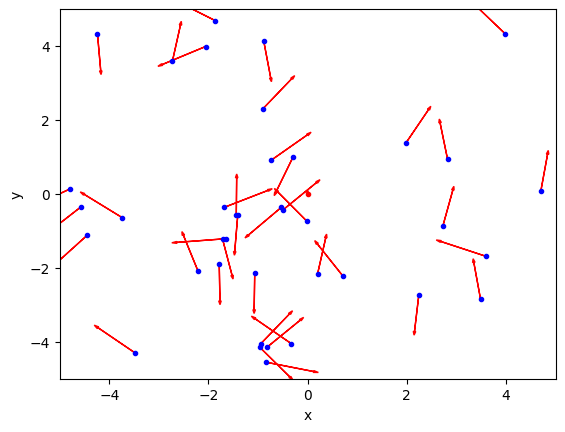

In [53]:
# Inspecteren van beginsituatie
plt.figure()

plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-Box_length_0,Box_length_0)
plt.ylim(-Box_length_0,Box_length_0)


for particle, particle_object in enumerate(particles):
    plt.plot(particle_object.r[0],particle_object.r[1],color=particle_object.c,marker='.')
    plt.arrow(particle_object.r[0],particle_object.r[1], 
               particle_object.v[0],particle_object.v[1], 
               head_width=0.05, head_length=0.1, color='red')
plt.show()


```{exercise} 
:label: ex-brownian-2

Er staat ook code met comments ervoor, wat doet deze code? 
Check je antwoord door de comments weg te halen.
Hoe wordt er voor gezorgd dat de snelheid van elk deeltje gelijk is?
```

```{solution} ex-brownian-2
Geeft de snelheidsvector van het deeltje weer, oftewel de richting waarin het deeltje beweegt
```

We gaan nu de functies van de simulatie weer aanroepen:

In [54]:
# Het bepalen of er een botsing plaats vindt
def collide_detection(self, other):
    dx = self.r[0] - other.r[0]
    dy = self.r[1] - other.r[1]
    rr = self.R + other.R
    return  dx**2+dy**2 < rr**2 
        
def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

#your code/answer
def handle_collisions(particles):
    """Alle onderlinge botsingen afhandelen en tellen"""
    num_particles = len(particles)
    count = 0  # lokale teller voor deze tijdstap
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            if particles[i].collide_detection(particles[j]):
                particle_collision(particles[i], particles[j])
                count += 1
    return count  # ← deze regel is essentieel!


In onderstaande code geven we de code voor de simulatie en volgen we de positie van het zware deeltje. 

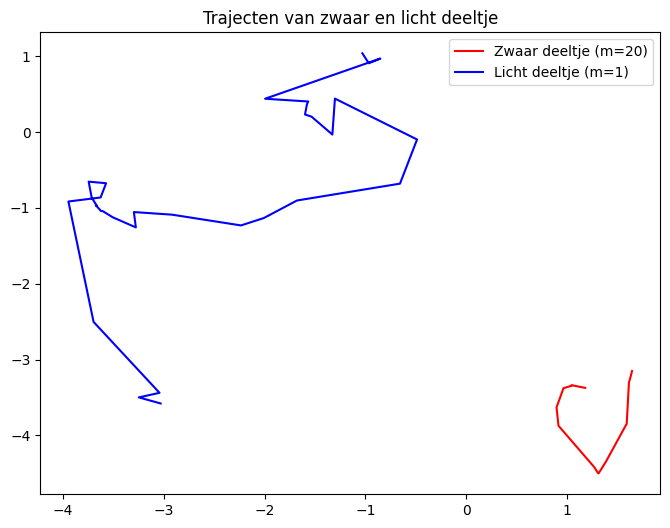

[2, 1, 2, 1, 2, 1, 2, 2, 1, 1]
{0, 1, 2, 3, 4, 5, 6}


In [65]:
# tracken van het zware deeltje
track_x_heavy = []
track_y_heavy = []

track_x_light = []
track_y_light = []

#your code/answer

#your code/answer

#your code/answer
collision_counts = []  # aantal botsingen per tijdstap

for i in range(400):
#your code/answer
    
    for p in particles:
        p.update_position()    # Update positie        
        p.boxcollision()         # Wandbotsing werkt per deeltje
 
# Botsingen afhandelen en tellen
    collisions = handle_collisions(particles)
    collision_counts.append(collisions)


#your code/answer
    

    track_x_heavy.append(particles[N-1].r[0])
    track_y_heavy.append(particles[N-1].r[1])

    track_x_light.append(particles[0].r[0])
    track_y_light.append(particles[0].r[1])
    
#your code/answer

#plt.figure()
#plt.plot(track_x,track_y,'r')
#your code/answer
#plt.show()

# Sla positie op van zwaar deeltje (laatste in lijst) en licht deeltje (eerste in lijst)



plt.figure(figsize=(8, 6))
plt.plot(track_x_heavy, track_y_heavy, 'r-', label='Zwaar deeltje (m=20)')
plt.plot(track_x_light, track_y_light, 'b-', label='Licht deeltje (m=1)')
plt.title('Trajecten van zwaar en licht deeltje')
plt.legend()
plt.show()
print(collision_counts[:10])
print(set(collision_counts))




```{exercise} Brownian motion in beeld
:label: ex-brownian-3
- Draai de onderstaande simulatie een keer en bestudeer de output.
- Voeg zelf een tweede tracking toe van een licht deeltje en verbeter de plot.
- Wat zijn overeenkomsten en verschillen tussen de beweging van de twee deeltjes?
- Wat valt je op als je de simulatie een aantal keer runt?
```

```{solution} ex-brownian-3
Hun beweging wordt bepaald door dezelfde regels: elastische botsingen, wandreflecties, en tijdstap-integratie. Het lichte deeltje volgt telkens een ander traject en het zware deeltje volgt telkens ongeveer hetzelfde traject. Het zware deeltje veranderd veel minder van positie.De totale energie en impuls blijven ongeveer behouden, maar de verdeling tussen deeltjes verandert voortdurend.

```

We zouden gevoel willen krijgen voor het aantal botsingen dat per tijdseenheid plaatsvindt. 
Elke keer dat er een botsing plaatsvindt, zou de counter met 1 omhoog moeten gaan.
Idealiter wordt het aantal botsingen opgeslagen in een array zodat je het aantal botsingen als functie van de tijd kunt weergeven.

```{exercise}
Pas bovenstaand idee toe in de eerder gemaakte code.
Plot hieronder het aantal botsingen als functie van de tijd.
```

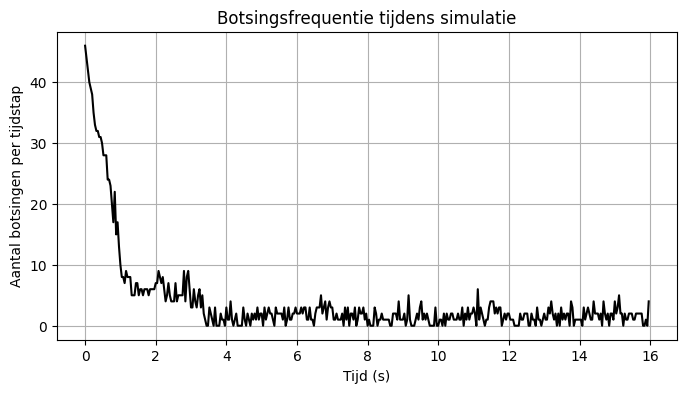

In [ ]:
#your code/answer
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(collision_counts)) * dt, collision_counts, 'k-')
plt.xlabel('Tijd (s)')
plt.ylabel('Aantal botsingen per tijdstap')
plt.title('Botsingsfrequentie tijdens simulatie')
plt.show()






```{warning} 🌶 Let op!
:icon: false
De onderstaande opdrachten vallen buiten de stof maar tellen mee als je excellent wilt behalen.
```

In zulke fysica modellen is de afgelegde weg (afstand tussen begin en eindpunt) van belang.
Deze afgelegde weg zegt iets over de snelheid van difussie.
Idealiter bekijken we een histogram.
Maar voor een histogram hebben we veel deeltjes nodig.



```{exercise} Afgelegde weg 🌶
:label: ex-brownian-4

- Maak een simulatie met 361 deeltjes, waarvan 1 zwaar deeltje.
- Houd rekening met de boxgrootte, deze moet mee schalen!
- Maak een histogram van de afgelegde weg voor alle deeltjes. 
- Geef de afgelegde weg van het grote deeltje duidelijk aan.
```


In [ ]:
#your code/answer


En nu we toch bezig zijn met twee verschillende deeltjes.... 

We kunnen twee "groepen" van deeltjes aanmaken, elk  met een andere massa. Als we dan de zwaartekracht aan zetten, dan zouden we verwachten dat de lichtere deeltjes boven komen "drijven".

```{exercise} Onderzoek dit vermoeden 🌶
- maak daartoe de box 2x zo hoog als breed
- verdubbel het totaal aantal deeltjes
- zet een artificieel grote zwaartekracht aan
```

In [ ]:
#your code/answer
